# (Static) Clustering FX Data

## 1 Summaryzing Time Series Data

Data Feeding for Training (and Updating) based on [Python YFinance API](https://github.com/ranaroussi/yfinance). Complete

In [2]:
# Cloud/Local Env Handling
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  PATH = "/content/drive/MyDrive/"
  PATH_INSTALL_REQUIREMENTS = "/content/drive/MyDrive/Colab\ Notebooks/requirements.txt"  
  import sys
  sys.path.append(PATH + "Colab Notebooks")
except:  
  import os
  if os.name=="nt":
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "\\requirements.txt"  
  else: #Unix system
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "/requirements.txt"  
  PATH=""

In [ ]:
%pip install -r {PATH_INSTALL_REQUIREMENTS}

import pandas as pd
import yfinance as yf
import riskfolio.RiskFunctions as rf
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import gc

# For Ratios with Extreme Values
from scipy.stats.mstats import winsorize

# For Serializing
import pickle

CONFIG_FILE = "./config.yaml"

In [28]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestCentroid
from yellowbrick.cluster import KElbowVisualizer

In [4]:
def config():
        with open(CONFIG_FILE,"r") as configfile:
            cfg=yaml.safe_load(configfile)
        
        countries = list()
        
        for land in cfg["currencies"].keys():
            countries.extend(cfg["currencies"][land])

        return countries

In [5]:
currencies = config()
print(currencies)

['AUD', 'CAD', 'JPY', 'NZD', 'NOK', 'GBP', 'SEK', 'CHF', 'USD', 'DKK', 'RUB', 'TRY', 'ZAR', 'HKD', 'INR', 'SGD', 'TWD', 'CNY', 'KRW', 'BRL', 'MXN']


In [6]:
CUT_DATE = "1998-01-02" # CONSTANT
tickers = ["EUR"+symbol+"=X" for symbol in currencies] 

In [7]:
data = yf.download(
    tickers=tickers,
    start=CUT_DATE    
)["Close"]

data.head()
# Insert Here a Adjusting Layer (Open, High, Low, ...) for taking into account Corporate Events

[*********************100%***********************]  21 of 21 completed


,EURAUD=X,EURBRL=X,EURCAD=X,EURCHF=X,EURCNY=X,EURDKK=X,EURGBP=X,EURHKD=X,EURINR=X,EURJPY=X,...,EURMXN=X,EURNOK=X,EURNZD=X,EURRUB=X,EURSEK=X,EURSGD=X,EURTRY=X,EURTWD=X,EURUSD=X,EURZAR=X
Date,,,,,,,,,,,,,,,,,,,,,
1998-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.4447,NaN,NaN,NaN,NaN,NaN
1998-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.4284,NaN,NaN,NaN,NaN,NaN
1998-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.3853,NaN,NaN,NaN,NaN,NaN
1998-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.3561,NaN,NaN,NaN,NaN,NaN
1998-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.3244,NaN,NaN,NaN,NaN,NaN


In [8]:
data.dropna(how="any", inplace=True)

In [9]:
data.head()

,EURAUD=X,EURBRL=X,EURCAD=X,EURCHF=X,EURCNY=X,EURDKK=X,EURGBP=X,EURHKD=X,EURINR=X,EURJPY=X,...,EURMXN=X,EURNOK=X,EURNZD=X,EURRUB=X,EURSEK=X,EURSGD=X,EURTRY=X,EURTWD=X,EURUSD=X,EURZAR=X
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-28,1.6993,2.6648,1.4037,1.57180,9.2724,7.4613,0.6888,9.3152,53.549999,141.419998,...,12.947,7.9434,1.9850,33.410999,9.3762,1.9469,1.6320,39.275002,1.201100,7.5463
2006-03-29,1.7019,2.6592,1.4101,1.57520,9.6227,7.4616,0.6932,9.3334,53.618999,141.660004,...,13.126,7.9763,1.9869,33.412998,9.4275,1.9503,1.6330,39.165001,1.203094,7.5409
2006-03-30,1.7006,2.6637,1.4082,1.57710,9.2881,7.4621,0.6963,9.4380,54.074001,142.679993,...,13.191,7.9651,1.9809,33.597000,9.4021,1.9670,1.6259,39.255001,1.216797,7.4991
2006-03-31,1.6897,2.6207,1.4140,1.58010,9.6896,7.4623,0.6969,9.3988,53.955002,142.639999,...,13.150,7.9363,1.9658,33.602001,9.4430,1.9322,1.6179,39.424999,1.211504,7.4496
2006-04-03,1.6985,2.5979,1.4213,1.58285,9.7035,7.4623,0.6975,9.4163,54.037998,142.949997,...,13.137,7.8690,2.0023,33.638000,9.3950,1.9611,1.6174,39.145000,1.213902,7.3973


In [10]:
prices = 1/data
prices.head()

,EURAUD=X,EURBRL=X,EURCAD=X,EURCHF=X,EURCNY=X,EURDKK=X,EURGBP=X,EURHKD=X,EURINR=X,EURJPY=X,...,EURMXN=X,EURNOK=X,EURNZD=X,EURRUB=X,EURSEK=X,EURSGD=X,EURTRY=X,EURTWD=X,EURUSD=X,EURZAR=X
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-28,0.588478,0.375263,0.712403,0.636213,0.107847,0.134025,1.451800,0.107351,0.018674,0.007071,...,0.077238,0.125891,0.503778,0.029930,0.106653,0.513637,0.612745,0.025461,0.83257,0.132515
2006-03-29,0.587579,0.376053,0.709170,0.634840,0.103921,0.134020,1.442585,0.107142,0.018650,0.007059,...,0.076185,0.125371,0.503297,0.029928,0.106073,0.512742,0.612370,0.025533,0.83119,0.132610
2006-03-30,0.588028,0.375418,0.710126,0.634075,0.107665,0.134011,1.436163,0.105955,0.018493,0.007009,...,0.075809,0.125548,0.504821,0.029765,0.106359,0.508388,0.615044,0.025474,0.82183,0.133349
2006-03-31,0.591821,0.381577,0.707214,0.632871,0.103203,0.134007,1.434926,0.106397,0.018534,0.007011,...,0.076046,0.126003,0.508699,0.029760,0.105899,0.517545,0.618085,0.025365,0.82542,0.134235
2006-04-03,0.588755,0.384926,0.703581,0.631772,0.103056,0.134007,1.433692,0.106199,0.018505,0.006995,...,0.076121,0.127081,0.499426,0.029728,0.106440,0.509918,0.618276,0.025546,0.82379,0.135184


In [17]:
# Summaryzing à la Mean-Variance
returns = 100*prices["2019":].pct_change().mean()*252
returns = pd.DataFrame(returns)
returns.columns = ["Returns"]
returns["Volatility"] = 100*prices["2019":].pct_change().std()*np.sqrt(252)
returns.head()

,Returns,Volatility
EURAUD=X,1.085072,8.785170
EURBRL=X,-4.311403,17.350140
EURCAD=X,2.074782,7.258580
EURCHF=X,3.492112,4.988994
EURCNY=X,1.780424,7.574522


In [18]:
returns.index = currencies

In [19]:
returns

,Returns,Volatility
AUD,1.085072,8.785170
CAD,-4.311403,17.350140
JPY,2.074782,7.258580
NZD,3.492112,4.988994
NOK,1.780424,7.574522
GBP,0.095649,0.261596
SEK,1.411003,10.867833
CHF,2.327747,7.218693
USD,-2.066466,8.362222
DKK,-3.382916,8.018366


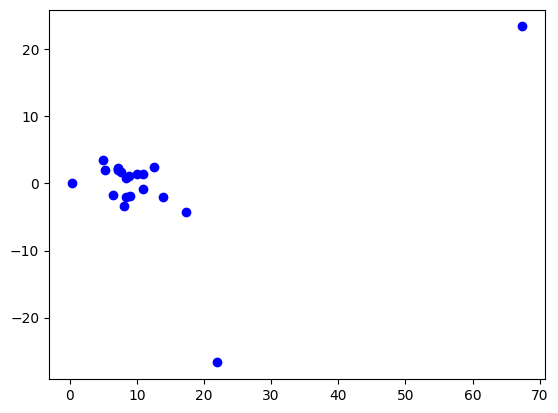

In [24]:
plt.plot(returns.iloc[:,1], returns.iloc[:,0],"bo")

In [ ]:
returns.drop(["CNY","INR"], inplace=True)


Text(0.5, 1.0, '3Y Mean-Variance Scatter for Currencies excluding INR and CNY')

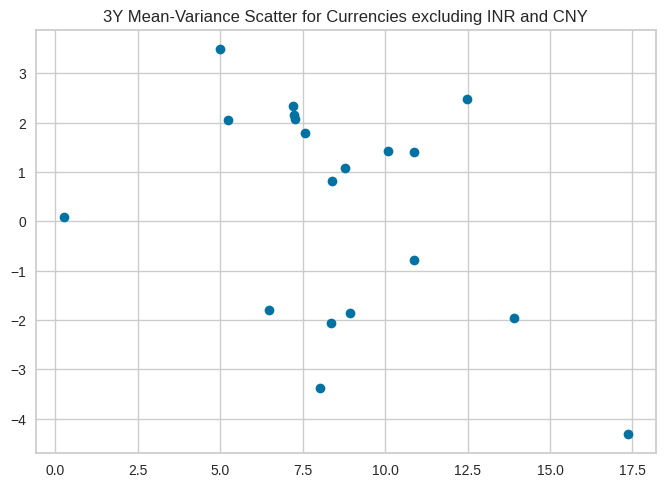

In [30]:
plt.plot(returns.iloc[:,1], returns.iloc[:,0],"bo")
plt.title("3Y Mean-Variance Scatter for Currencies excluding INR and CNY")

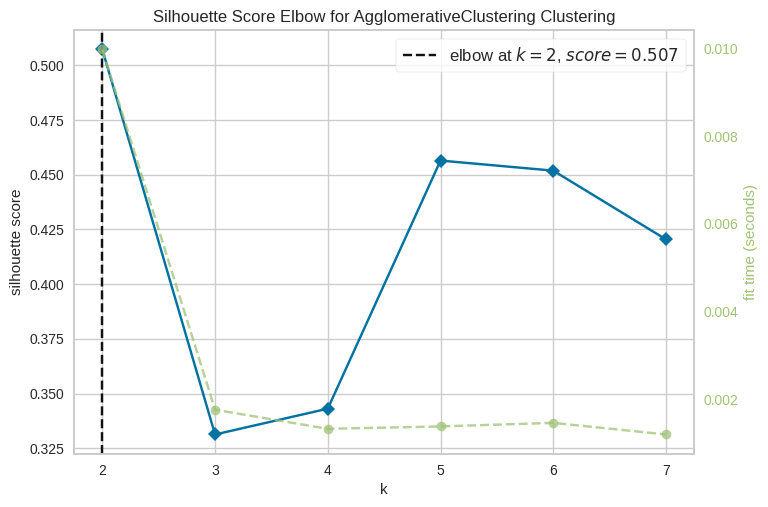

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:
# Putting names of currency invested from € investor point of view (G10 Countries)
aglomerativo =AgglomerativeClustering()
visualizer = KElbowVisualizer(aglomerativo, k=(2,8),metric='silhouette')
visualizer.fit(returns)      
visualizer.show() 

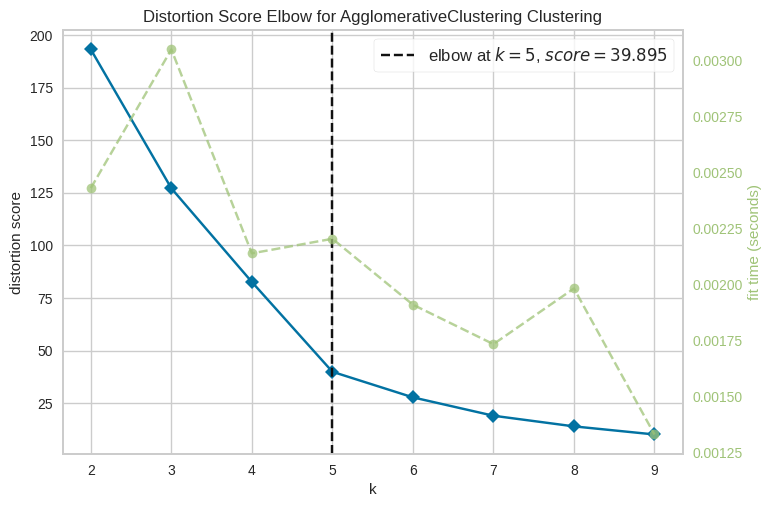

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
aglomerativo =AgglomerativeClustering()
visualizer = KElbowVisualizer(aglomerativo, k=(2,10))
visualizer.fit(returns)      
visualizer.show() 

Text(0.5, 1.0, 'Davies Bouldin index')

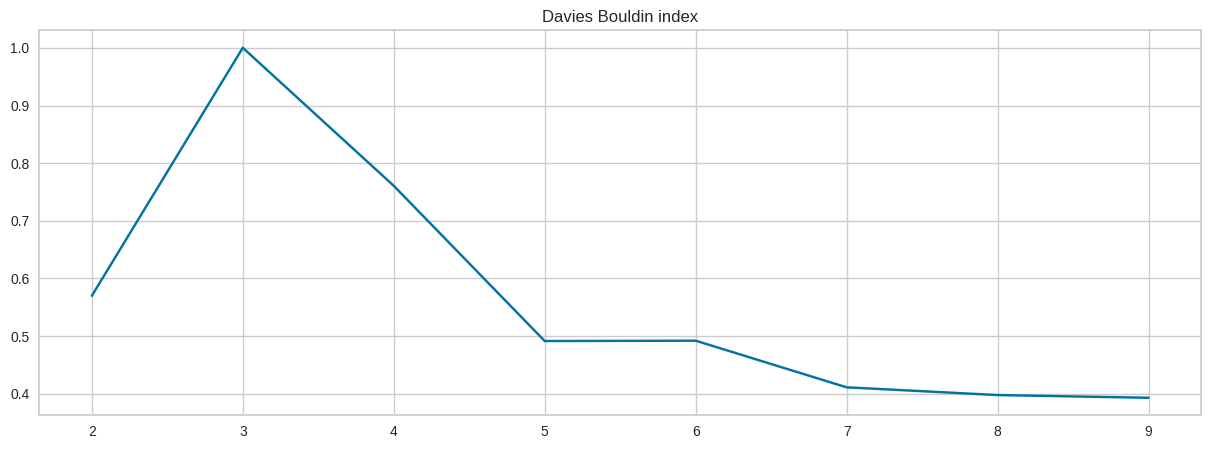

In [34]:
dbindex=[]

for k in range(2, 10):
    agg=AgglomerativeClustering(n_clusters=k)
    agg.fit(returns)
    dbindex.append(davies_bouldin_score(returns, agg.labels_))

fig=plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), dbindex)
plt.xticks(range(2, 10))
plt.title('Davies Bouldin index')

In [35]:
# computing Agglomerative clustering with 4 clusters
agg=AgglomerativeClustering(n_clusters=5)
agg.fit(returns)

# assign each sample to a cluster
idx=agg.labels_

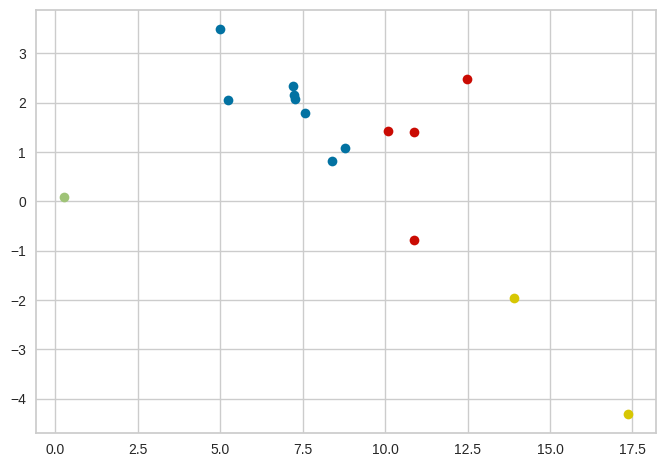

In [36]:
# some plotting using numpy's logical indexing
plt.plot(returns[idx==0]["Volatility"], returns[idx==0]["Returns"], 'ob',
     returns[idx==1]["Volatility"], returns[idx==1]["Returns"], 'oy',
     returns[idx==2]["Volatility"], returns[idx==2]["Returns"], 'or',
     returns[idx==3]["Volatility"], returns[idx==3]["Returns"], 'og')